In [180]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt

import random as rd
import math

rd.seed(54321)

# Vehicle Routing Problem

The Vehicle Routing Problem (VRP) is a fundamental problem in operations research that focuses on optimizing the routes taken by a fleet of vehicles to service a set of customers. The primary goal is to minimize the total cost, which can include distance traveled, time spent, or other operational costs while ensuring that certain constraints are met.

#### Key Components of VRP:

1. **Depot**: The starting and ending point for all vehicles, typically where goods are stored.

2. **Customers**: Locations that require service (e.g., delivery of goods).

3. **Vehicles**: A fleet of vehicles that will service the customers.

4. **Constraints**: Various limitations that can include:
    - **Capacity constraints**: Each vehicle can carry only a limited amount of goods.
    - **Time windows**: Certain customers must be served within specific time frames.
    - **Distance limits**: Restrictions on how far a vehicle can travel.
5. **Objective**: The most common objectives are to minimize the total distance traveled, reduce total delivery time, or minimize operational costs.



#### **Number of Customers**

In [181]:
n = 15

#### **Number of Vehicles**

In [182]:
k = 3

#### **Capacity of Vehicles**

In [183]:
C = 20

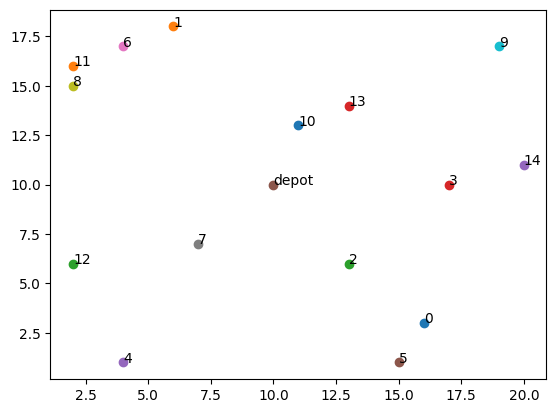

In [184]:
rd.seed(54321)

data = {i: {'x': rd.randint(1,20), 'y': rd.randint(1,20), 'cap': rd.randint(1,6)} for i in range(n)}

data['depot'] = {'x': 10, 'y': 10, 'cap': 0}

for i in data:
    x = data[i]['x']
    y = data[i]['y']
    plt.scatter(x,y)
    plt.text(x,y,i)

#### **Distance Function**

In [185]:
def dist(x1,y1,x2,y2):
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

#### **Mathematical Model**

1. **Objective** \
Our objective is to minimize the total distance the vehicles encounter in their routes.
$$
\min \sum_{k=1}^{K} \sum_{i = 1}^{n} \sum_{j = 1}^{n} d_{ij} x_{ijk}
$$

2. **Constraints**

\begin{align}
\sum_{i = 1}^{n} x_{ijk} &= \sum_{i = 1}^{n} x_{jik} \quad \forall j \in \{1, \ldots, n\}, k = \{1, \ldots, K\}\\
\sum_{k = 1}^{K}\sum_{i = 1}^{n} x_{ijk} &= 1 \quad \forall j \in \{1, \ldots, n\} \backslash depot \\
x_{jjk}& = 0 \quad \forall j \in \{1, \ldots, n\}, k = \{1, \ldots, K\} \\
\sum_{j = 1, j\neq {depot}}^{n} x_{{depot}jk}& = 1 \quad \forall k = \{1, \ldots, K\}\\
\sum_{i \in V} cap_i * x_{ijk} &\leq C \quad \forall k = \{1, \ldots, K\} \\
x_{ijk} &\in \{0, 1\} \quad \forall i, j \in V, k = \{1, \ldots, K\}
\end{align}

- Constraint (1) ensures that the number of times a vehicle enters a node is equal to the number of times a vehicle exits a node.
- Constraint (2) ensures that all nodes are visited once.
- Constraint (3) ensures that no vehicle visits a node from the same node, i.e. traveling from node 1 to node 1.
- Constraint (4) ensures that all vehilces leave from the depot.
- Constraint (5) ensures that capacity constraints of each vehicle are not violated during their route.
- Constraint (6) defines $x$ as a binary variable.

In [186]:
model = cp_model.CpModel()
solver = cp_model.CpSolver()

x = {(i,j,v): model.NewBoolVar(f'x_{i}_{j}_{v}') for i in data.keys() for j in data.keys() for v in range(k)}

for j in data.keys():

    for v in range(k):
        # Vehicles leave node that they enter
        model.Add(sum(x[i,j,v] for i in data.keys()) == sum(x[j,i,v] for i in data.keys()))

        # Nodes don't enter themselves
        model.Add(x[j,j,v] == 0)

    if j != 'depot':
        # All nodes entered once
        model.Add(sum(x[i,j,v] for i in data.keys() for v in range(k)) == 1)

for v in range(k):
    # Vehicles leave depot
    model.Add(sum(x['depot',j,v] for j in data.keys() if j != 'depot') == 1)

    # Respect capacity constraints of each vehicle
    model.Add(sum(data[j]['cap'] * x[i,j,v] for i in data.keys() for j in data.keys() if j != 'depot') <= C)

# Minimize total distance
model.Minimize(sum(x[i,j,v] * dist(data[i]['x'],data[i]['y'],data[j]['x'],data[j]['y']) for i,j,v in x))

status = solver.Solve(model)
print(f'Status = {solver.StatusName(status)}')

Status = OPTIMAL


Total Capacity
['0: 14', '1: 16', '2: 15']


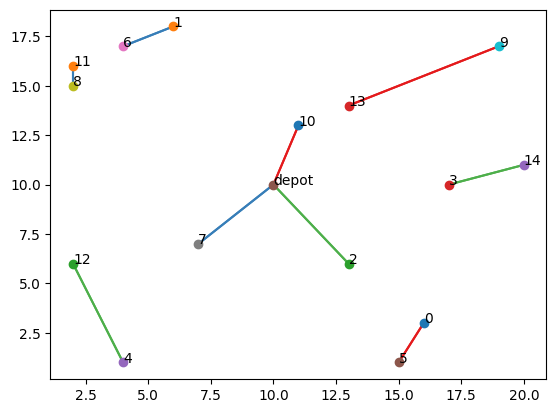

In [187]:
print('Total Capacity')
print([f'{v}: {sum(data[j]["cap"] for i,j,q in sol if q == v)}' for v in range(k)])

color = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']

sol = [(i,j,v) for v in range(k) for i in data.keys() for j in data.keys() if solver.value(x[i,j,v]) == 1]

for i in data:
    a = data[i]['x']
    b = data[i]['y']
    plt.scatter(a,b)
    plt.text(a,b,i)
    
for v in range(k):
    for a,b,c in sol:
        if c == v:
            pass
            plt.plot((data[a]['x'], data[b]['x']),(data[a]['y'], data[b]['y']), color = color[v], zorder = 0)

#### **Subtour elimination (Miller-Tucker-Zemlin Formulation)**

Our solution, although feasible, does not render a sensible solution. This is because subtours are currently allowed in our model. The constraints below ensure that subtours are eliminated from our model using the Miller-Tucker-Zemlin (MTZ) formulation.

Constraint (7) defines a dummy variable $u_i$ as an integer variable that will contain the values at each node crossed. Constraint (8) ensures that when a vehicle $k$ travels from node $i$ to node $j$, then the value of $u_{j}$ must be greater than that of $u_{i}$. So the path 'depot-2-4-2' is not allowed as that would mean the value of $u_{4}$ is both greater than and less than the value of $u_{2}$. Constraint (9) bounds the possible values for $u$, allowing for a more efficient model. Further information about MTZ formulation can be found [here](https://how-to.aimms.com/Articles/332/332-Miller-Tucker-Zemlin-formulation.html).

$$
\begin{align}
u_{i} & \in \mathbb{Z} & \forall i \in \{1, \ldots, n\}  \\
u_{j} - u_{i} & \geq cap_{j} - C^{*}(1 - x_{i,j,k}) & \forall i,j \in V \backslash {depot} \quad i \neq j \\
cap_{i} \leq u_{i} & \leq C & \forall i \in \{1, \ldots, n\}
\end{align}
$$

In [188]:
u = {i: model.NewIntVar(0, len(data), f'u_{i}') for i in range(len(data))}

for v in range(k):
    for i in data.keys():
        for j in data.keys():
            if i != 'depot' and j != 'depot':
                # Subtour elimination constraint
                model.Add(u[j] - u[i] >= data[j]['cap'] - C*(1 - x[i,j,v]))

for i in data.keys():
    if i != 'depot':
        # Bounds for u
        model.Add(data[i]['cap'] <= u[i])
        model.Add(u[i] <= C)

status = solver.Solve(model)
print(f'Status = {solver.StatusName(status)}')

Status = OPTIMAL


Total Capacity
['0: 13', '1: 15', '2: 17']


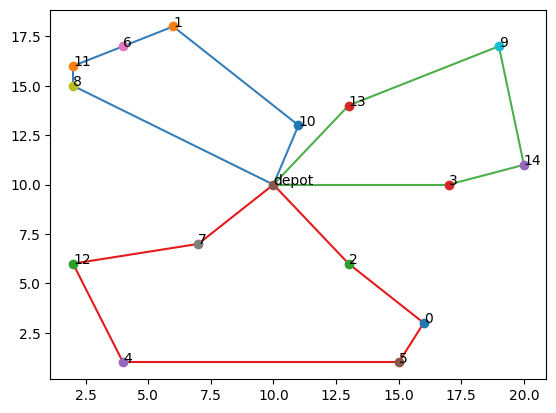

In [189]:
print('Total Capacity')
print([f'{v}: {sum(data[j]["cap"] for i,j,q in sol if q == v)}' for v in range(k)])

color = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']

sol = [(i,j,v) for v in range(k) for i in data.keys() for j in data.keys() if solver.value(x[i,j,v]) == 1]

for i in data:
    a = data[i]['x']
    b = data[i]['y']
    plt.scatter(a,b)
    plt.text(a,b,i)
    
for v in range(k):
    for a,b,c in sol:
        if c == v:
            pass
            plt.plot((data[a]['x'], data[b]['x']),(data[a]['y'], data[b]['y']), color = color[v], zorder = 0)